[2020-02-03 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 159919.XSHE
[2020-02-03 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 510500.XSHG
[2020-02-10 15:00:00.000000] INFO: user_log: 中证500期货价格: 3880.0 现货价格: 3.9619999999999997 .反向套利
[2020-02-11 15:00:00.000000] INFO: user_log: 中证500期货价格: 3917.4 现货价格: 4.01 .平仓
[2020-02-12 15:00:00.000000] INFO: user_log: 中证500期货价格: 3947.4 现货价格: 4.038 .平仓
[2020-02-13 15:00:00.000000] INFO: user_log: 中证500期货价格: 3930.2 现货价格: 4.0169999999999995 .平仓
[2020-02-24 15:00:00.000000] INFO: user_log: 中证500期货价格: 4106.2 现货价格: 4.181 .平仓
[2020-03-02 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 510390.XSHG
[2020-03-02 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 510500.XSHG
[2020-03-10 15:00:00.000000] INFO: user_log: 中证500期货价格: 4050.6 现货价格: 4.224 .平仓
[2020-03-23 15:00:00.000000] INFO: user_log: 沪深300期货价格: 3470.2 现货价格: 3.655 .反向套利
[2020-04-01 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 510390.XSHG
[2020-04-01 00:00:00.000000] INFO: user_log: 本月选取ETF标的为： 510500.XSHG
[202

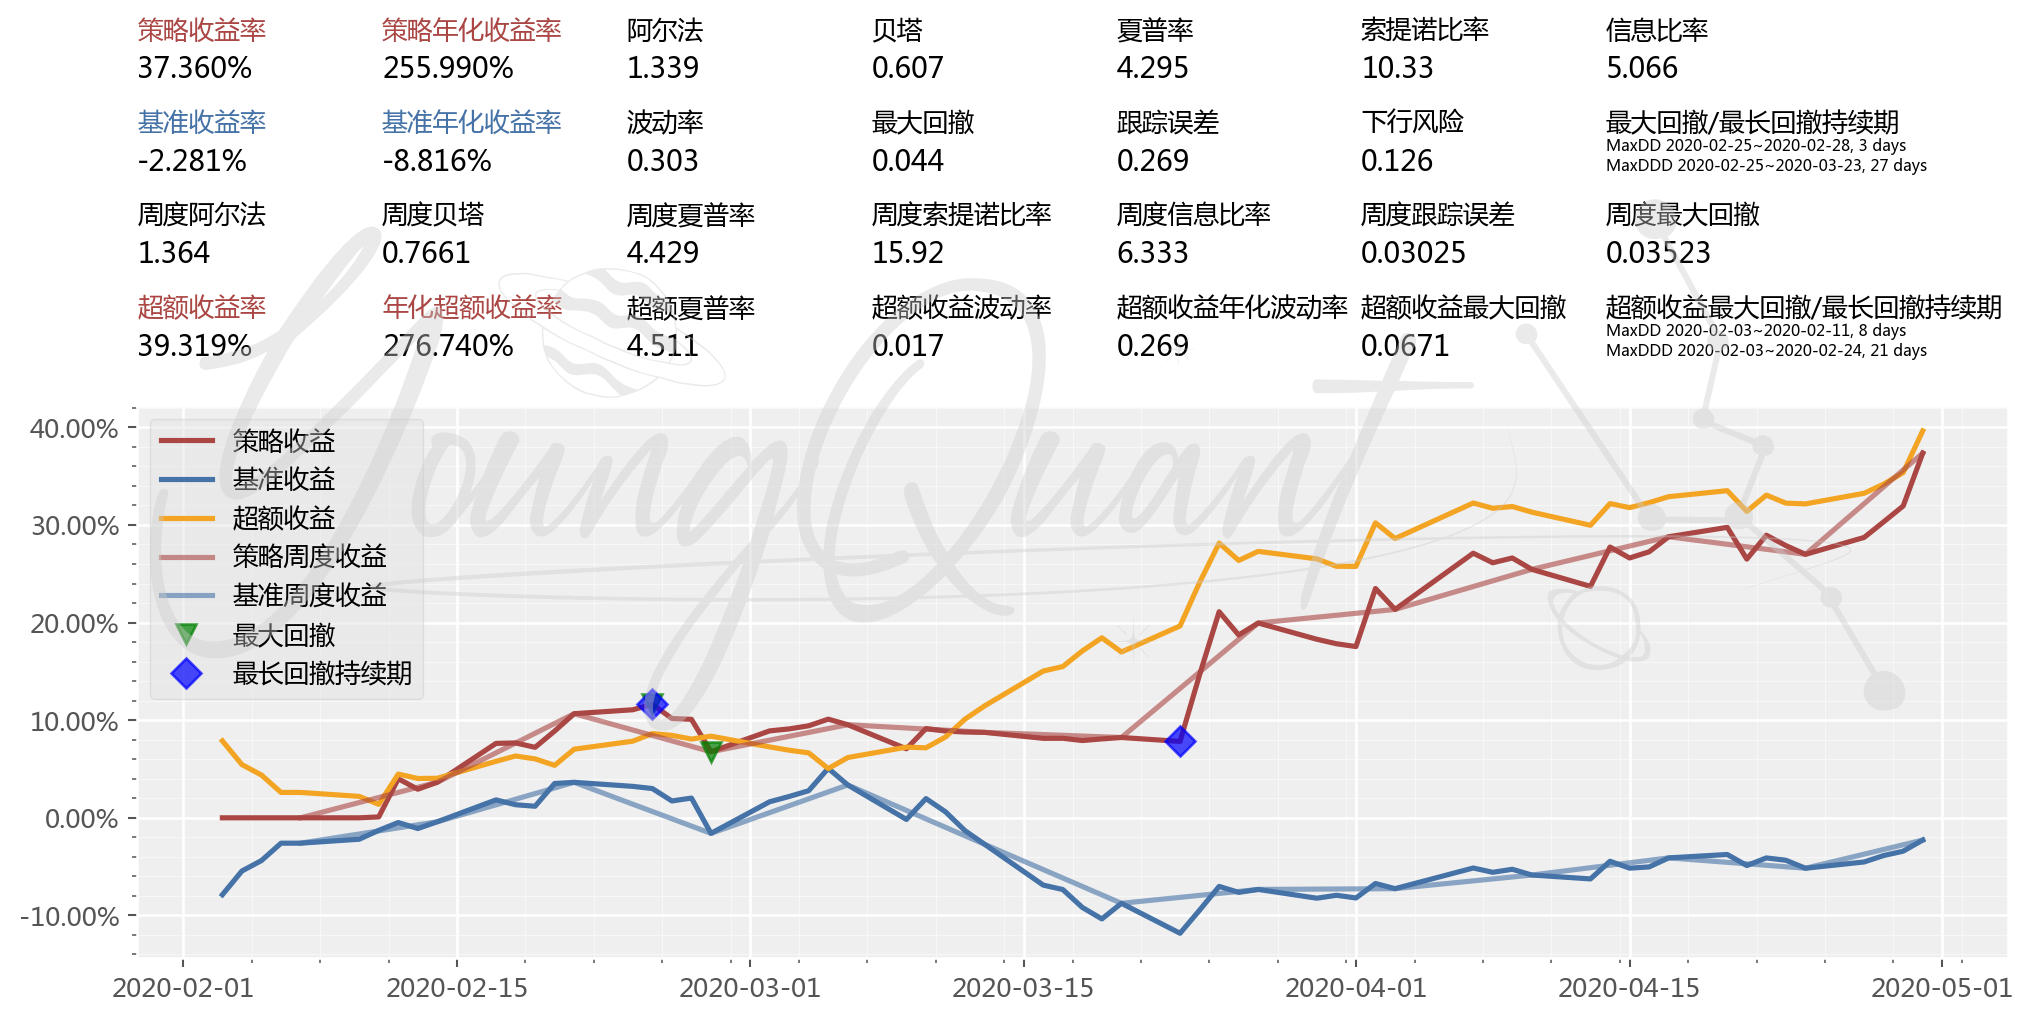

In [88]:
from rqalpha.api import *
from rqalpha import run_func
import pandas as pd
import numpy as np
import statsmodels.api as sm
import talib
import warnings

config = {
  "base": {
    "start_date": "2020-02-01",
    "end_date": "2020-05-01",
    "frequency": "1d",
    "margin_multiplier":0.8,
    "benchmark": "000300.XSHG",
    "future_info": {
      # 期货品种
      '300IF': {
          # 平仓费率
          'close_commission_ratio': 0.000023,
          # 开仓费率
          'open_commission_ratio': 0.000023,
          # 平今费率
          'close_commission_today_ratio': 0,
          # BY_MONEY 为按照名义价值收取, BY_VOLUME 为根据成交合约张数收取
          'commission_type': 'BY_VOLUME',
      },
    },
    "plot": True,
    "accounts": {
        "stock": 5000000,
        "future":5000000
    }
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    },
      "sys_transaction_cost": {
        "commission_multiplier": 0
      },
    "mongodb": {
        "enabled": True,
    }
  }
} 

def get_reference(context,bar_dict):
    context.etf_300,context.ratio_300 = get_sub_reference(context.etf_300_dict,context.fu_300_6)
    context.etf_500,context.ratio_500 = get_sub_reference(context.etf_500_dict,context.fu_500_6)

def get_sub_reference(etf_dict,future_name):
    regression = pd.DataFrame(columns=['slope','var'],index = etf_dict)
    future_reg = history_bars(future_name, 60 ,'1d','close') 
    mincov = 0.0
    selected_etf = ''
    ratio = 0.0
    for item in etf_dict:
        etf_reg = np.array(history_bars(item, 60 ,'1d','close'))
        try:
            results = sm.OLS(future_reg, etf_reg).fit()
            slope = results.params
            #print(item,'斜率：',slope,'方差：',np.var(etf_reg*slope))
            #print(results.summary())
            if np.var(etf_reg) > mincov:
                mincov = np.var(etf_reg)
                selected_etf = item
                ratio = slope[0]
        except:
            continue
    print('本月选取ETF标的为：',selected_etf)  
    return selected_etf,ratio
    
def init(context):
    context.fu_300_6 = 'IF2006'
    context.fu_500_6 = 'IC2006'
    context.ratio_300 = 0.0
    context.ratio_500 = 0.0
    context.etf_300 = ''
    context.etf_500 = ''
    context.etf_300_dict = ['159919.XSHE','510300.XSHG','510310.XSHG','510330.XSHG','510350.XSHG','510360.XSHG','510380.XSHG',
                            '510390.XSHG','512270.XSHG','515310.XSHG','515330.XSHG','515360.XSHG','515390.XSHG']
    context.etf_500_dict = ['159922.XSHE','159922.XSHE','159968.XSHE','510500.XSHG','510510.XSHG','510530.XSHG','510550.XSHG',
                           '510560.XSHG','510580.XSHG','510590.XSHG','510600.XSHG','512260.XSHG','512500.XSHG','512510.XSHG','515550.XSHG',]
    context.Flag300 = False
    context.Flag500 = False
    scheduler.run_monthly(get_reference, tradingday=1, time_rule='before_trading')
    
                
def handle_bar(context,bar_dict):
    a = history_bars(context.fu_300_6, 20 ,'1d','close')
    b = history_bars(context.etf_300, 1 ,'1d','close')
    c = history_bars(context.fu_500_6, 20 ,'1d','close')
    d = history_bars(context.etf_500, 1 ,'1d','close')
    if context.Flag300:
        if abs(a[-1] - b[-1] * context.ratio_300) < a[-1] * 0.0040:
            order_target_percent(context.etf_300, 0)
            sell_close(context.fu_300_6, 3, price=None, style=None, close_today=False)
            buy_close(context.fu_300_6, 3, price=None, style=None, close_today=False)
            sell_close(context.fu_300_6, 1, price=None, style=None, close_today=False)#当总张数不为4的倍数时，保证能全平
            buy_close(context.fu_300_6, 1, price=None, style=None, close_today=False)
            print('沪深300期货价格:',a[-1],'现货价格:',b[-1],'.平仓')
            if not get_position(context.fu_300_6).equity:
                context.Flag300 = False
    else:
        if b[-1] * context.ratio_300 < a[-1] - a[-1] * 0.0088:
            order_value(context.etf_300, 2500000*0.8)
            sell_open(context.fu_300_6, int(2500000*0.8/a[-1]), price=None, style=None)
            print('沪深300期货价格:',a[-1],'现货价格:',b[-1],'.正向套利')
            context.Flag300 = True
        if b[-1] * context.ratio_300 > a[-1] + a[-1] * 0.0088:
            macd_300, signal_300, hist_300 = talib.MACD(a, 3,10, 3)
            if macd_300[-1] - signal_300[-1] > 0 and macd_300[-2] - signal_300[-2] > 0:
                buy_open(context.fu_300_6, int(2500000*0.8/300/0.08/a[-1]), price=None, style=None)
                print('沪深300期货价格:',a[-1],'现货价格:',b[-1],'.反向套利')
                context.Flag300 = True
    if context.Flag500:
        if abs(c[-1] - d[-1] * context.ratio_500) < c[-1] * 0.0040:
            order_target_percent(context.etf_500, 0)
            sell_close(context.fu_500_6, 3, price=None, style=None, close_today=False)
            buy_close(context.fu_500_6, 3, price=None, style=None, close_today=False)
            sell_close(context.fu_500_6, 1, price=None, style=None, close_today=False)#当总张数不为4的倍数时，保证能全平
            buy_close(context.fu_500_6, 1, price=None, style=None, close_today=False)
            print('中证500期货价格:',a[-1],'现货价格:',b[-1],'.平仓')
            if get_position(context.fu_500_6).pnl == 0.0:
                context.Flag500 = False
    else:
        if d[-1] * context.ratio_500 < c[-1] - c[-1] * 0.0088:
            order_value(context.etf_500, 2500000*0.8)
            sell_open(context.fu_500_6, int(2500000*0.8/c[-1]), price=None, style=None)
            print('中证500期货价格:',a[-1],'现货价格:',b[-1],'.正向套利')
            context.Flag300 = True
        if d[-1] * context.ratio_500 > c[-1] + c[-1] * 0.0088:
            macd_500, signal_500, hist_500 = talib.MACD(c, 3,10, 3)
            if macd_500[-1] - signal_500[-1] > 0 and macd_500[-2] - signal_500[-2] > 0:
                buy_open(context.fu_500_6, int(2500000*0.8/300/0.08/a[-1]), price=None, style=None)
                print('中证500期货价格:',a[-1],'现货价格:',b[-1],'.反向套利')
                context.Flag500 = True
    
results=run_func(init=init, handle_bar=handle_bar, config=config)